# Exploration_9
## Chest X-Ray Images (Pneumonia Detection)
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다. - 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
2. 데이터 준비, 모델구성 등 과정의 다양한 실험이 체계적으로 수행되었다. - regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다. - Accuracy 기준 85%에 도달하였다.

### 1. 실험환경 Set-up
* Batch size, Epoch 등을 변경해보자!

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


### 2. 데이터 가져오기
* 원본 데이터를 가져와서 전처리 및 배치 구성을 진행한다.
* 의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않다. 이를 극복 할 수 있는 방법을 고민해보자.
* 좌우 반전 정도의 augmentation을 도입해보자!

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[1000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person260_virus_541.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person437_bacteria_1884.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1062
Pneumonia images count in training set: 3123


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" # 폐렴이면 양성(TRUE), 노말이면 음성(FALSE

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 unit8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print('Image shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# 좌우반전 augmentation 추가
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤하게 좌우를 반전합니다.
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # agument 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 3. 데이터 시각화
* 시도한 augmentation이 show_batch() 함수를 통해 실제로 좌우 반전이 제대로 처리되었는지 확인해보자!

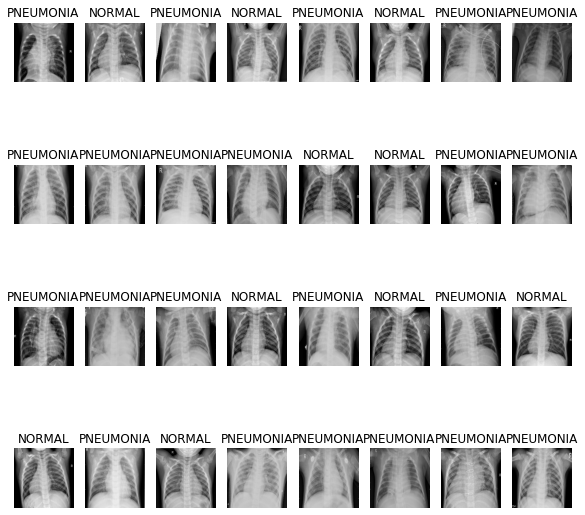

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4. CNN 모델링
* Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어보자!
* BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습해보았는데, 일반적으로 잘 사용되는 형태는 아니라고 한다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 한다.
* BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있다. 또한 Dropout 비율을 변경해볼 수도 있다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3) # dropout_rate = 0.3 으로 지정해주었다. (보통 0,2~0.5 사용)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 5. 데이터 imbalance 처리
* 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었다.
* recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까?

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.97
Weight for PNEUMONIA: 0.67


### 6. 모델 훈련
* loss함수를 변경하기는 어렵지만, optimizer나 learning rate 등의 변화를 고려해보자!

In [20]:
from tensorflow import keras
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    # adam = keras.optimizers.Adam(learning_rate=0.01) : learning_rate를 변경해보았다.(회고 참조)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # 이미지의 라벨이 2개이기 때문에 이진크로스엔트로피 지정해줌.
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 60s 365ms/step - loss: 0.3043 - accuracy: 0.8565 - precision: 0.9690 - recall: 0.8345 - val_loss: 0.6196 - val_accuracy: 0.7236 - val_precision: 0.7236 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 371ms/step - loss: 0.1855 - accuracy: 0.9286 - precision: 0.9769 - recall: 0.9262 - val_loss: 0.7423 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 49s 377ms/step - loss: 0.1503 - accuracy: 0.9450 - precision: 0.9806 - recall: 0.9450 - val_loss: 1.1835 - val_accuracy: 0.7295 - val_precision: 0.7295 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 50s 384ms/step - loss: 0.1331 - accuracy: 0.9526 - precision: 0.9843 - recall: 0.9515 - val_loss: 2.1848 - val_accuracy: 0.7246 - val_precision: 0.7246 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 54s 414ms/step - loss: 0.1411 - accura

### 7. 결과 확인과 시각화
* 테스트 데이터로 훈련된 모델을 평가해보자.
* 우선은 accuracy를 고려해야겠지만 **의료 영상 모델의 특성상 recall도 중요**하다.
* 훈련과정의 history그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해보자!

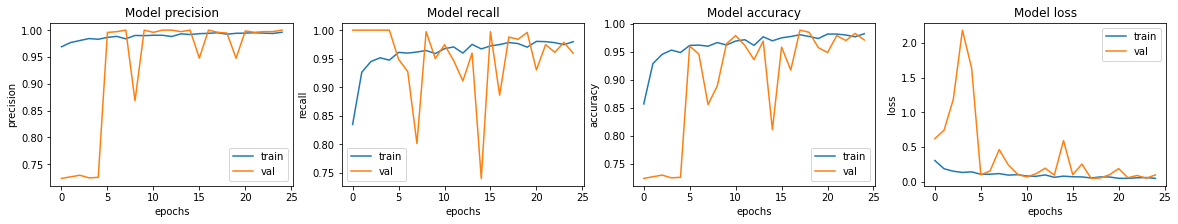

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, \nAccuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}')

20/20 [==============================] - 4s 215ms/step - loss: 0.5444 - accuracy: 0.8718 - precision: 0.8523 - recall: 0.9615
Loss: 0.544357419013977, 
Accuracy: 0.8717948794364929, 
Precision: 0.8522727489471436, 
Recall: 0.9615384340286255


## 회고
### 결론 (test set에 대하여)
    * Accuracy : 87%
    * Recall : 96%
    * Loss : 0.54
---
아래에 표시한 accuracy는 모두 test set에 대한 값이다.  
1. BATCH_SIZE : 16 -> 32 -> 16 -> 21 -> 32 -> 32
2. EPOCH : 25 -> 10 -> 30 -> 30 -> 30 -> 25    
이제 BATCH_SIZE와 EPOCH 값은 고정해준다. (32, 25)   
그런데, 여기서 아무런 규칙이나 이론 없이 BATCH_SIZE와 EPOCH값이 Accuracy에 영향을 주는 것인지 의문이 든다...   
그리고 실행시킬 때마다 Accuracy가 동일하지 않고 불안정하다. 85%였다가 77%로 뚝 떨어지는 경우도 있었다.   
이때 정확도를 다시 올릴 방법 중 하나로 dropout_rate=0.3으로 지정하여 87%까지 올렸다. (train set에 과대적합되었다고 판단하였다!)
3. 여러가지 하이퍼파라미터들을 다양한 값으로 적용시켜보았다.   
adam의 learning_rate : default는 0.001 인데 0.01로 지정해준 뒤 학습시켜보았다.
    
Accuracy      | 0.001 | 0.01
--------------|-------|------
learning_rate |  87%  | 74%
    
4. BatchNormalization   

Accuracy           | 적용 | 적용 X
-------------------|-----|------
BatchNormalization | 87% | 62%
Dropout            | 87% | 75%